In [1]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

from networkgen import Network, NetworkType
from model import OpinionModel, OpinionAgent, Opinion

In [65]:
#n, p = 100, 0.3 # DEFAULT
#n, k, p = 100, 10, 0.2 # SMALLWORLD
#l, k = 10, 5 # CAVEMAN
#n, s, v, p_in, p_out = 100, 5, 10, 0.3, 0.1 # GAUSSIAN_RANDOM_PARTITION
#n, k = 100, 10 # WINDMILL
#n, p = 100, 0.02  # ERDOS_RENYI
l, k, p, f = 6, 5, 0.1, 0.1 # RELAXED_CAVEMAN

network_params = (l, k, p, f)

initial_believers = 0.1
initial_skeptics = 0.0  # for now 0, but might change later

prob_S_with_I = 0.1
prob_S_with_Z = 0.1
agent_params = OpinionAgent.Params(
    initial_opinion=Opinion.SUSCEPTIBLE,
    prob_S_with_I=prob_S_with_I,
    prob_S_with_Z=prob_S_with_Z
)

model = OpinionModel(initial_believers, initial_skeptics, agent_params, network_type=NetworkType.RELAXED_CAVEMAN, network_params=network_params)

In [66]:
model.run(7)

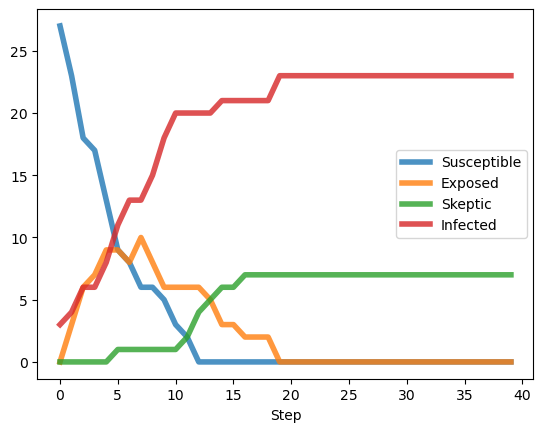

In [62]:
#convenience function to collect plotable data
def sum_agents(model):

    agent_data = model.data_collector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
    # relabel
    labels = ['Susceptible','Exposed', 'Skeptic', "Infected"]
    agents_summed.columns = labels
    return agents_summed

sum_agents(model)

def plot_agent_opinion(model):
    steps = model.schedule.steps
    X = sum_agents(model)
    X.plot(lw = 4, alpha = 0.8)

plot_agent_opinion(model)

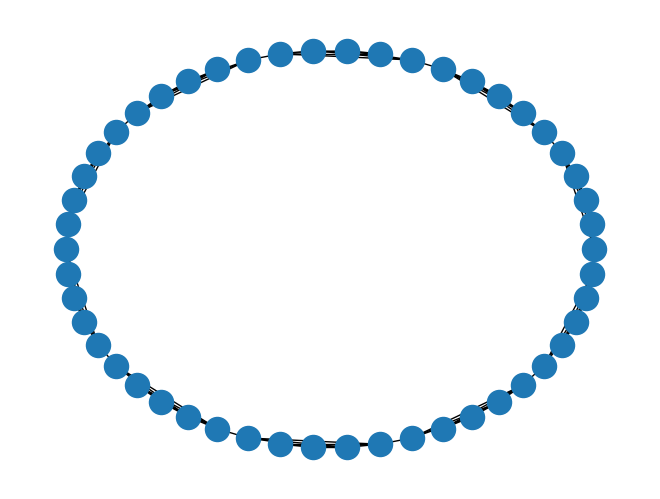

In [94]:
Network.visualize(NetworkType.SMALLWORLD, model.network)

10.483333333333333


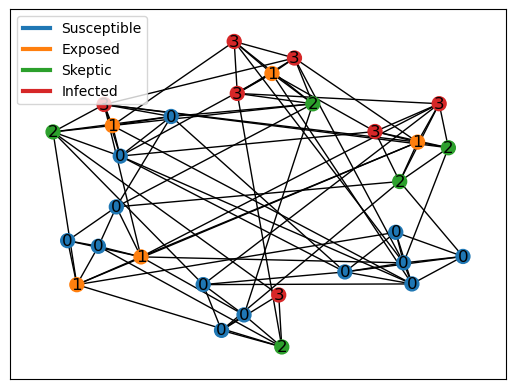

In [67]:
#color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

#states = [int(i.state) for i in model.grid.get_all_cell_contents()]

#colors = [color_code(i) for i in states]

from matplotlib.lines import Line2D

def draw_network(with_labels=False):
    node_states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    cmap = ListedColormap(list(mpl.colors.TABLEAU_COLORS.values())[:4])

    legend = [Line2D([0], [0], color=cmap(0), lw=3),
                Line2D([0], [0], color=cmap(1), lw=3),
                Line2D([0], [0], color=cmap(2), lw=3),
                    Line2D([0], [0], color=cmap(3), lw=3)]
    #node_color = [cmap[s] for s in node_states]
    #edge_weights = [model.network.edges[u, v]['weight'] for u, v in model.network.edges]
    #layout = nx.kamada_kawai_layout(model.network, weight=1.0, scale=10)
    dummy = nx.connected_caveman_graph(6, 5)
    layout=nx.kamada_kawai_layout(dummy)
    #layout = nx.circular_layout(model.network, scale=10)
    nx.draw_networkx(model.network, pos=layout, node_size = 100, arrowsize=5.0, node_color=node_states, cmap=cmap, with_labels=with_labels, labels={i: node_states[i] for i in range(len(node_states))})
    #plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=cmap))
    plt.legend(legend, ['Susceptible','Exposed', 'Skeptic', "Infected"])

print(np.mean(model.network.degree()))
draw_network(True)

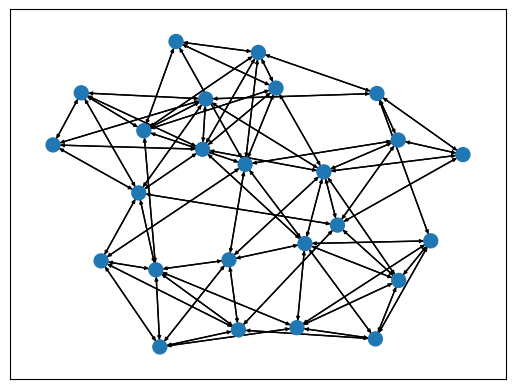

In [41]:
def draw_network_discrete():
    color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    colors = [color_code(i) for i in states]

    layout = nx.kamada_kawai_layout(model.network, weight=1.0, scale=10)
    nx.draw_networkx(model.network, pos=layout, node_size = 100, arrowsize=5.0, width=1.0, node_color=colors, with_labels=False)

draw_network_discrete()

In [20]:
for i in tqdm(range(100)):
    #print(f"i={i}")
    ##draw_network_discrete()
    #draw_network()
    #plt.show()
    if i % 100 == 0 and False:
        plt.hist([agent.state for agent in model.grid.get_all_cell_contents()], range=(0,1), bins=20)
        plt.show()
    model.step()

100%|██████████| 100/100 [00:00<00:00, 5595.09it/s]


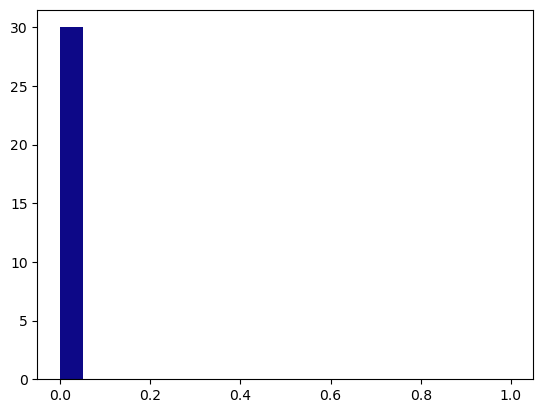

In [27]:
def draw_histogram():
    # This is  the colormap I'd like to use.
    cm = plt.cm.plasma

    # Plot histogram.
    n, bins, patches = plt.hist([agent.state for agent in model.grid.get_all_cell_contents()], range=(0,1), bins=20)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

draw_histogram()

In [4]:
[agent.state for agent in model.grid.get_all_cell_contents()]

[1.0,
 0.8657583263486882,
 0.8295866244077619,
 1,
 1.0,
 0,
 1,
 1,
 0.23777963480183967,
 1.0,
 1.0,
 0,
 1.0,
 0.3730268692922468,
 0.8829584336331646,
 0,
 1,
 0,
 1,
 0.24511500127804842,
 1.0,
 0,
 1,
 0.48827442865677767,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1.0,
 0.26265493401353923,
 1,
 0,
 1,
 1,
 0.3699622884027477,
 0.48741644949796836,
 0.6344429157033808,
 0.7055466927683051,
 0,
 0.10161038401541617,
 0.8389459507583586,
 0.19981409123421245,
 0,
 0.6819690507026879,
 0.20659307352152512,
 0.16310696967486987,
 1,
 0,
 0,
 0.12068053919962618,
 1,
 0.39497964500790184,
 0.46667644167151223,
 0,
 0.4346576372037651,
 0.7426982381327106,
 1,
 0,
 0,
 0.3237318147151436,
 0.3916533412572223,
 0.9759984594439204,
 0.9591663840248188,
 1.0,
 0,
 0.4375696290691365,
 0,
 0.6953867256149254,
 1,
 1,
 0.7996222379271732,
 0,
 0.3775808970687661,
 1,
 1,
 0.25798866008805243,
 1,
 0,
 0.5546100181522196,
 1,
 0.37764896934592385,
 1,
 0,
 0.34302112434763377,
 0.6678313420110432,
 1.0,

In [39]:
list(mpl.colors.TABLEAU_COLORS.values())

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']